In [1]:
import os
import json
from collections import defaultdict
import pandas as pd

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.special import softmax
from scipy.stats import entropy

from fairseq import tasks, options

In [2]:
MODEL_PATH = 'mtransformer/de-en/'
CHECKPOINT_PATHS = [
    'model1.pt',
    'model2.pt',
    'model3.pt',
    'model4.pt',
    'model5.pt',
]
CHECKPOINT_PATHS = [os.path.join(MODEL_PATH, path) for path in CHECKPOINT_PATHS]

MODEL_PATH = ':'.join(CHECKPOINT_PATHS)
BINARY_DATA_PATH = 'data-bin/iwslt14.tokenized.de-en/'
# BPECODES_PATH = 'wmt19.en-ru.ensemble/codes'
BPECODES_PATH = 'data/iwslt14.tokenized.de-en/code' # иначе лажа какая-то получается
BEAM = '5'
LENPEN = '0.6'
DIVERSE_BEAM_STRENGTH = '0'
SHARED_BPE = True
SRS = "en"
TGT = "ru"

parser = options.get_generation_parser(interactive=True)

args = options.parse_args_and_arch(parser, input_args=[
    BINARY_DATA_PATH,
    '--path', MODEL_PATH,
    '--diverse-beam-strength', DIVERSE_BEAM_STRENGTH,
    '--lenpen', 0,
    '--remove-bpe',
    '--beam', BEAM
])

use_cuda = False
task = tasks.setup_task(args)
tgt_dict = task.target_dictionary

| [de] dictionary: 8848 types
| [en] dictionary: 6632 types


In [3]:
MODELS_NUM = 5

---

#### Моделирование softmax

In [4]:
def plot_softmax(tokens, probs, title, label, ax, f_ylim=True): 
    ax.plot(tokens, probs, alpha=.5, label=label)
    ax.scatter(tokens, probs, alpha=.5)
    if f_ylim:
        ax.set_ylim(0, 1)
    ax.set_xlabel('token')
    ax.set_ylabel('token prob $p(y)$')
    ax.set_title(title + ' softmax')
    ax.grid()
    ax.legend()

In [5]:
def plot_single_stats(
    beams,
    beam2stats,
    stat,
    title,
    xlabel,
    ylabel,
    xlim,
    ylim,
    normalized=True,
    eos_token=None,
    map_func=lambda x: x
):
    density = stacked = normalized
        
    m = 3
    n = len(beams) // m  + (1 if len(beams) % m != 0 else 0)

    pos_name, beam2stats_pos = beam2stats
    
    plt.figure(figsize=(8 * m, 6 * n))
    for i, beam in enumerate(sorted(beams)):
        ax = plt.subplot(n, m, i + 1)
        ax.hist(
            map_func(beam2stats_pos[beam][stat]),
            density=density, stacked=stacked,
            color='red', alpha=.4,
            bins=70,
            label='{} ({})'.format(pos_name, len(beam2stats_pos[beam][stat]))
        )
        if eos_token is not None:
            pos_stats = np.array(beam2stats_pos[beam][stat])
            mask = np.array(beam2stats_pos[beam]['tokens']) == eos_token
            ax.hist(
                map_func(pos_stats[mask]),
                density=density, stacked=stacked,
                color='gold', alpha=.4,
                bins=70,
                label='{}(eos) ({})'.format(pos_name, pos_stats[mask].shape[0])
            )
            
        ax.set_title('Beam Size: {}. {}'.format(beam, title))
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if ylim is not None:
            ax.set_ylim(ylim)
        if xlim is not None:
            ax.set_xlim(xlim)
        ax.grid()
        ax.legend()

In [6]:
def plot_stats(
    beams,
    beam2stats_pos,
    beam2stats_neg,
    beam2stats_wrong,
    stat,
    title,
    xlabel,
    ylabel,
    xlim,
    ylim,
    normalized=True,
    eos_token=None,
    map_func=lambda x: x
):
    density = stacked = normalized
        
    m = 2
    n = len(beams)

    pos_name, beam2stats_pos = beam2stats_pos
    neg_name, beam2stats_neg = beam2stats_neg
    wrong_name, beam2stats_wrong = beam2stats_wrong
    
    plt.figure(figsize=(8 * m, 6 * n))
    for i, beam in enumerate(sorted(beams)):
        ax = plt.subplot(n, m, m * i + 1)
        ax.hist(
            map_func(beam2stats_pos[beam][stat]),
            density=density, stacked=stacked,
            color='red', alpha=.4,
            bins=70,
            label='{} ({})'.format(pos_name, len(beam2stats_pos[beam][stat]))
        )
        if eos_token is not None:
            pos_stats = np.array(beam2stats_pos[beam][stat])
            mask = np.array(beam2stats_pos[beam]['tokens']) == eos_token
            ax.hist(
                map_func(pos_stats[mask]),
                density=density, stacked=stacked,
                color='gold', alpha=.4,
                bins=70,
                label='{}(eos) ({})'.format(pos_name, pos_stats[mask].shape[0])
            )
            
        ax.hist(
            map_func(beam2stats_neg[beam][stat]),
            density=density, stacked=stacked,
            color='blue', alpha=.4,
            bins=70,
            label='{} ({})'.format(neg_name, len(beam2stats_neg[beam][stat]))
        )
        if eos_token is not None:
            neg_stats = np.array(beam2stats_neg[beam][stat])
            mask = np.array(beam2stats_neg[beam]['tokens']) == eos_token
            ax.hist(
                map_func(neg_stats[mask]),
                density=density, stacked=stacked,
                color='green', alpha=.4,
                bins=70,
                label='{} (eos) ({})'.format(neg_name, neg_stats[mask].shape[0])
            )
        ax.set_title('Beam Size: {}. {}'.format(beam, title))
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if ylim is not None:
            ax.set_ylim(ylim)
        if xlim is not None:
            ax.set_xlim(xlim)
        ax.grid()
        ax.legend()

        ax = plt.subplot(n, m, m * i + 2)
        wrong_stat = np.array(beam2stats_wrong[beam][stat])
        pos_mask = np.array(beam2stats_wrong[beam]['is_true'])
        if eos_token is not None:
            eos_mask = np.array(beam2stats_wrong[beam]['tokens']) == eos_token
        ax.hist(
            map_func(wrong_stat[pos_mask]),
            density=density, stacked=stacked,
            color='red', alpha=.4,
            bins=70,
            label='{} positive ({})'.format(wrong_name, wrong_stat[pos_mask].shape[0])
        )
        if eos_token is not None:
            ax.hist(
                map_func(wrong_stat[pos_mask & eos_mask]),
                density=density, stacked=stacked,
                color='gold', alpha=.4,
                bins=70,
                label='{} positive(eos) ({})'.format(wrong_name, wrong_stat[pos_mask & eos_mask].shape[0])
            )
        ax.hist(
            map_func(wrong_stat[~pos_mask]),
            density=density, stacked=stacked,
            color='blue', alpha=.4,
            bins=70,
            label='{} negative ({})'.format(wrong_name, wrong_stat[~pos_mask].shape[0])
        )
        if eos_token is not None:
            ax.hist(
                map_func(wrong_stat[(~pos_mask) & eos_mask]),
                density=density, stacked=stacked,
                color='green', alpha=.4,
                bins=70,
                label='{} negative(eos) ({})'.format(wrong_name, wrong_stat[(~pos_mask) & eos_mask].shape[0])
            )
        ax.set_title('Beam Size: {}. {}'.format(beam, title))
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if ylim is not None:
            ax.set_ylim(ylim)
        if xlim is not None:
            ax.set_xlim(xlim)
        ax.grid()
        ax.legend()

In [7]:
def plot_stats_scatters(
    beams,
    beam2stats_first,
    beam2stats_second,
    stat_x,
    stat_y,
    title,
    xlabel,
    ylabel,
    xlim,
    ylim,
    normalized=True,
    eos_token=None,
    map_func_x=lambda x: x,
    map_func_y=lambda x: x
):
    density = stacked = normalized
        
    m = 2
    n = len(beams)

    first_name, beam2stats_first = beam2stats_first
    second_name, beam2stats_second = beam2stats_second
    
    plt.figure(figsize=(8 * m, 6 * n))
    for i, beam in enumerate(sorted(beams)):
        ax = plt.subplot(n, m, m * i + 1)
        ax.scatter(
            map_func_x(beam2stats_first[beam][stat_x]),
            map_func_y(beam2stats_first[beam][stat_y]),
            color='red', alpha=.4,
            label='{}'.format(first_name)
        )
        if eos_token is not None:
            stats_x = np.array(beam2stats_first[beam][stat_x])
            stats_y = np.array(beam2stats_first[beam][stat_y])
            mask = np.array(beam2stats_first[beam]['tokens']) == eos_token
            ax.scatter(
                map_func_x(stats_x[mask]),
                map_func_y(stats_y[mask]),
                color='gold', alpha=.4,
                label='{}(eos)'.format(first_name)
            )
            
        ax.set_title('Beam Size: {}. {}'.format(beam, title))
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if ylim is not None:
            ax.set_ylim(ylim)
        if xlim is not None:
            ax.set_xlim(xlim)
        ax.grid()
        ax.legend()

        ax = plt.subplot(n, m, m * i + 2)
        ax.scatter(
            map_func_x(beam2stats_second[beam][stat_x]),
            map_func_y(beam2stats_second[beam][stat_y]),
            color='blue', alpha=.4,
            label='{}'.format(second_name)
        )
        if eos_token is not None:
            stats_x = np.array(beam2stats_second[beam][stat_x])
            stats_y = np.array(beam2stats_second[beam][stat_y])
            mask = np.array(beam2stats_second[beam]['tokens']) == eos_token
            ax.scatter(
                map_func_x(stats_x[mask]),
                map_func_y(stats_y[mask]),
                color='green', alpha=.4,
                label='{}(eos)'.format(second_name)
            )
        ax.set_title('Beam Size: {}. {}'.format(beam, title))
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if ylim is not None:
            ax.set_ylim(ylim)
        if xlim is not None:
            ax.set_xlim(xlim)
        ax.grid()
        ax.legend()

In [8]:
stats_dir = 'mtransformer/de-en/stats/'

positive_filename = 'positive_stats.json'
negative_filename = 'negative_stats.json'
negative_true_filename = 'negative_true_stats.json'
wrong_filename = 'wrong_suff_stats.json'
random_filename = 'random_stats.json'

In [9]:
beam2stats_pos = defaultdict(list)
beam2stats_neg = defaultdict(list)
beam2stats_neg_true = defaultdict(list)
beam2stats_wrong = defaultdict(list)
beam2stats_random = defaultdict(list)

In [10]:
for beam_dir in os.listdir(stats_dir):
    beam = int(beam_dir.split('_')[-1])
    
    path = os.path.join(stats_dir, beam_dir)
    with open(os.path.join(path, positive_filename)) as input_stream:
        beam2stats_pos[beam] = json.load(input_stream)
        
    with open(os.path.join(path, negative_filename)) as input_stream:
        beam2stats_neg[beam] = json.load(input_stream)
        
    with open(os.path.join(path, negative_true_filename)) as input_stream:
        beam2stats_neg_true[beam] = json.load(input_stream)
        
    with open(os.path.join(path, wrong_filename)) as input_stream:
        beam2stats_wrong[beam] = json.load(input_stream)
        
    with open(os.path.join(path, random_filename)) as input_stream:
        beam2stats_random[beam] = json.load(input_stream)

#### Log probs

In [11]:
beams = list(beam2stats_pos.keys())

---

In [12]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [13]:
scaler = lambda x: (x - x.min()) / (x.max() - x.min())

beam2missclassification = defaultdict(list)
beam2entropy = defaultdict(list)

for beam in beams:
    beam2missclassification[beam] += beam2stats_pos[beam]['missclassification']
    beam2entropy[beam] += beam2stats_pos[beam]['softmax_probs_entropy_ens']
    
for beam in beams:
    beam2missclassification[beam] += beam2stats_wrong[beam]['missclassification']
    beam2entropy[beam] += beam2stats_wrong[beam]['softmax_probs_entropy_ens']
    
for beam in beams:
    beam2missclassification[beam] = np.array(beam2missclassification[beam])
    beam2entropy[beam] = scaler(np.array(beam2entropy[beam]))

In [14]:
for beam in sorted(beams):
    print(beam, 'beam size')
    print(
        '\tPositive class ratio: {:.2f}'.format(
            np.mean(beam2missclassification[beam])
        )
    )

1 beam size
	Positive class ratio: 0.26
5 beam size
	Positive class ratio: 0.25
9 beam size
	Positive class ratio: 0.25
20 beam size
	Positive class ratio: 0.25
50 beam size
	Positive class ratio: 0.25


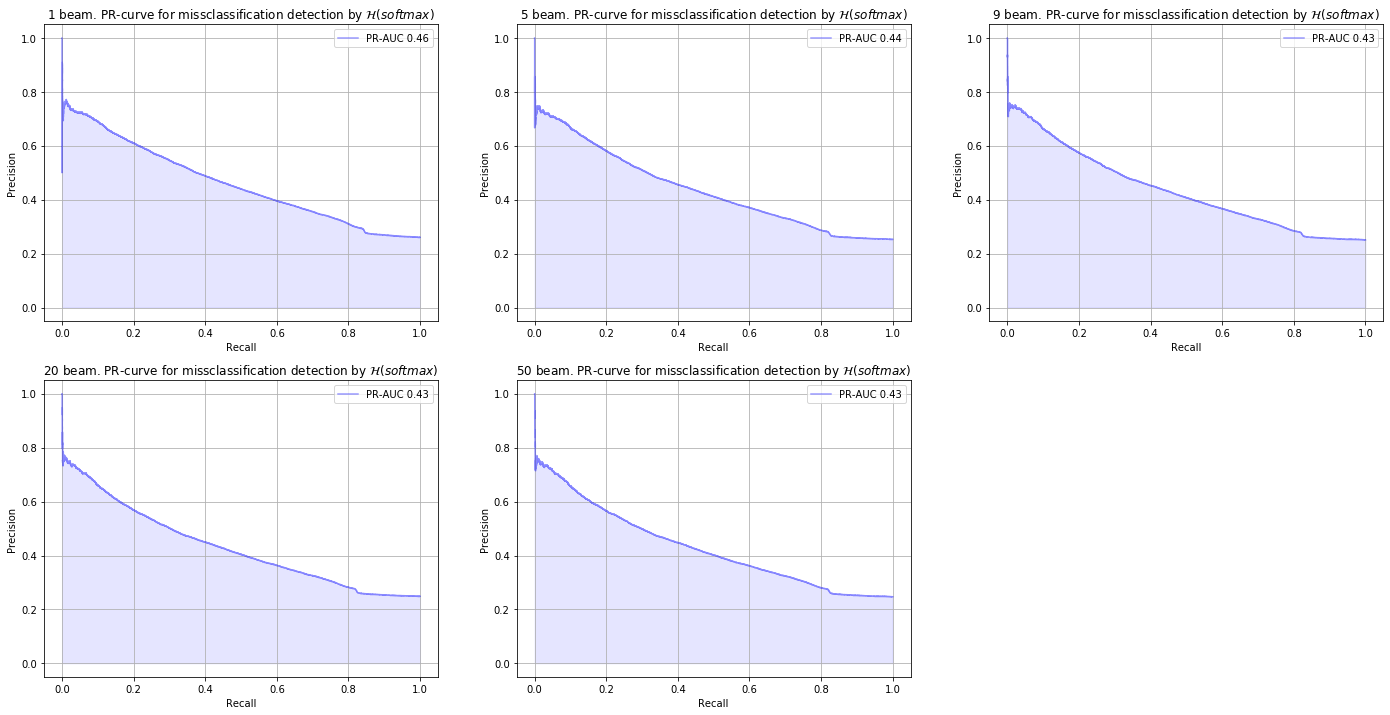

In [15]:
m = 3
n = len(beams) // m + (1 if len(beams) % m != 0 else 0)

plt.figure(figsize=(8 * m, 6 * n))
for i, beam in enumerate(sorted(beams)):
    ax = plt.subplot(n, m, i + 1)
    
    precision, recall, tr = precision_recall_curve(
        beam2missclassification[beam],
        beam2entropy[beam]
    )
    
    ax.plot(
        recall,
        precision,
        alpha=.4,
        label='PR-AUC {:.2f}'.format(auc(recall, precision)),
        color='b'
    )
    ax.fill_between(recall, precision, alpha=0.1, color='b')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(str(beam) + ' beam. PR-curve for missclassification detection by $\mathcal{H}(softmax)$')
    ax.grid()
    ax.legend()

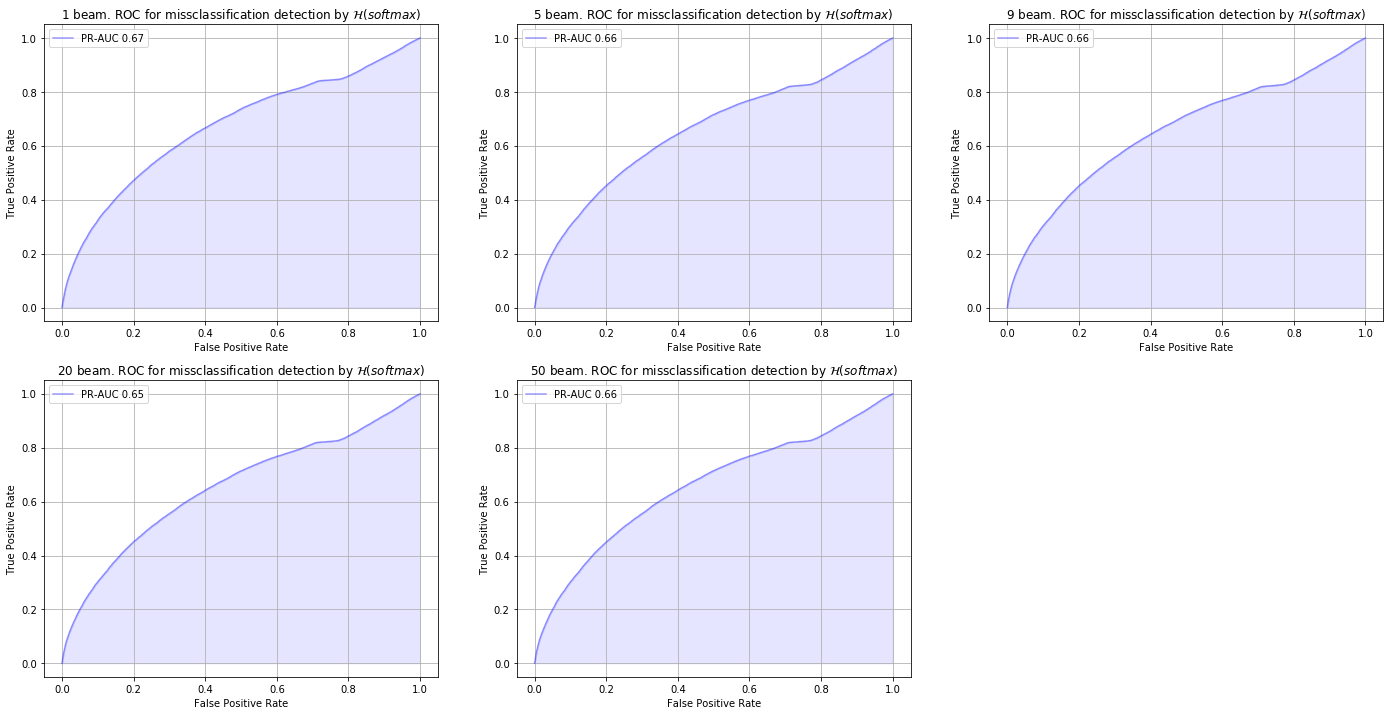

In [16]:
m = 3
n = len(beams) // m + (1 if len(beams) % m != 0 else 0)

plt.figure(figsize=(8 * m, 6 * n))
for i, beam in enumerate(sorted(beams)):
    ax = plt.subplot(n, m, i + 1)
    
    fpr, tpr, tr = roc_curve(
        beam2missclassification[beam],
        beam2entropy[beam]
    )
    
    ax.plot(
        fpr,
        tpr,
        alpha=.4,
        label='PR-AUC {:.2f}'.format(auc(fpr, tpr)),
        color='b'
    )
    ax.fill_between(fpr, tpr, alpha=0.1, color='b')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(str(beam) + ' beam. ROC for missclassification detection by $\mathcal{H}(softmax)$')
    ax.grid()
    ax.legend()

---

#### Position missclassification

In [17]:
scaler = lambda x: (x - x.min()) / (x.max() - x.min())

beam2missclassification = defaultdict(list)
beam2entropy = defaultdict(list)

for beam in beams:
    x = beam2stats_pos[beam]['softmax_probs_entropy_ens']
    beam2entropy[beam] += x
    beam2missclassification[beam] += [True] * len(x)
    
for beam in beams:
    beam2missclassification[beam] += beam2stats_wrong[beam]['is_true']
    beam2entropy[beam] += beam2stats_wrong[beam]['softmax_probs_entropy_ens']
    
for beam in beams:
    beam2missclassification[beam] = ~np.array(beam2missclassification[beam])
    beam2entropy[beam] = scaler(np.array(beam2entropy[beam]))

In [18]:
for beam in sorted(beams):
    print(beam, 'beam size')
    print(
        '\tPositive class ratio: {:.2f}'.format(
            np.mean(beam2missclassification[beam])
        )
    )

1 beam size
	Positive class ratio: 0.77
5 beam size
	Positive class ratio: 0.76
9 beam size
	Positive class ratio: 0.76
20 beam size
	Positive class ratio: 0.76
50 beam size
	Positive class ratio: 0.76


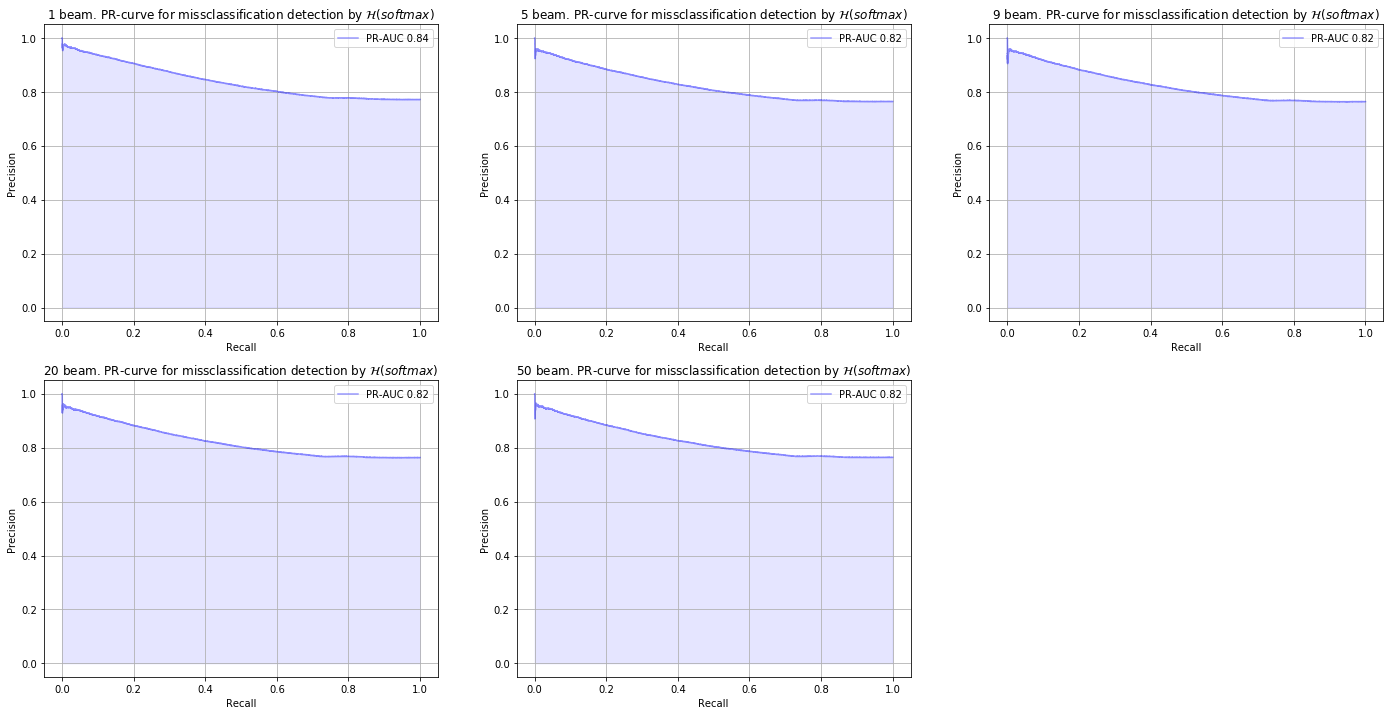

In [19]:
m = 3
n = len(beams) // m + (1 if len(beams) % m != 0 else 0)

plt.figure(figsize=(8 * m, 6 * n))
for i, beam in enumerate(sorted(beams)):
    ax = plt.subplot(n, m, i + 1)
    
    precision, recall, tr = precision_recall_curve(
        beam2missclassification[beam],
        beam2entropy[beam]
    )
    
    ax.plot(
        recall,
        precision,
        alpha=.4,
        label='PR-AUC {:.2f}'.format(auc(recall, precision)),
        color='b'
    )
    ax.fill_between(recall, precision, alpha=0.1, color='b')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(str(beam) + ' beam. PR-curve for missclassification detection by $\mathcal{H}(softmax)$')
    ax.grid()
    ax.legend()

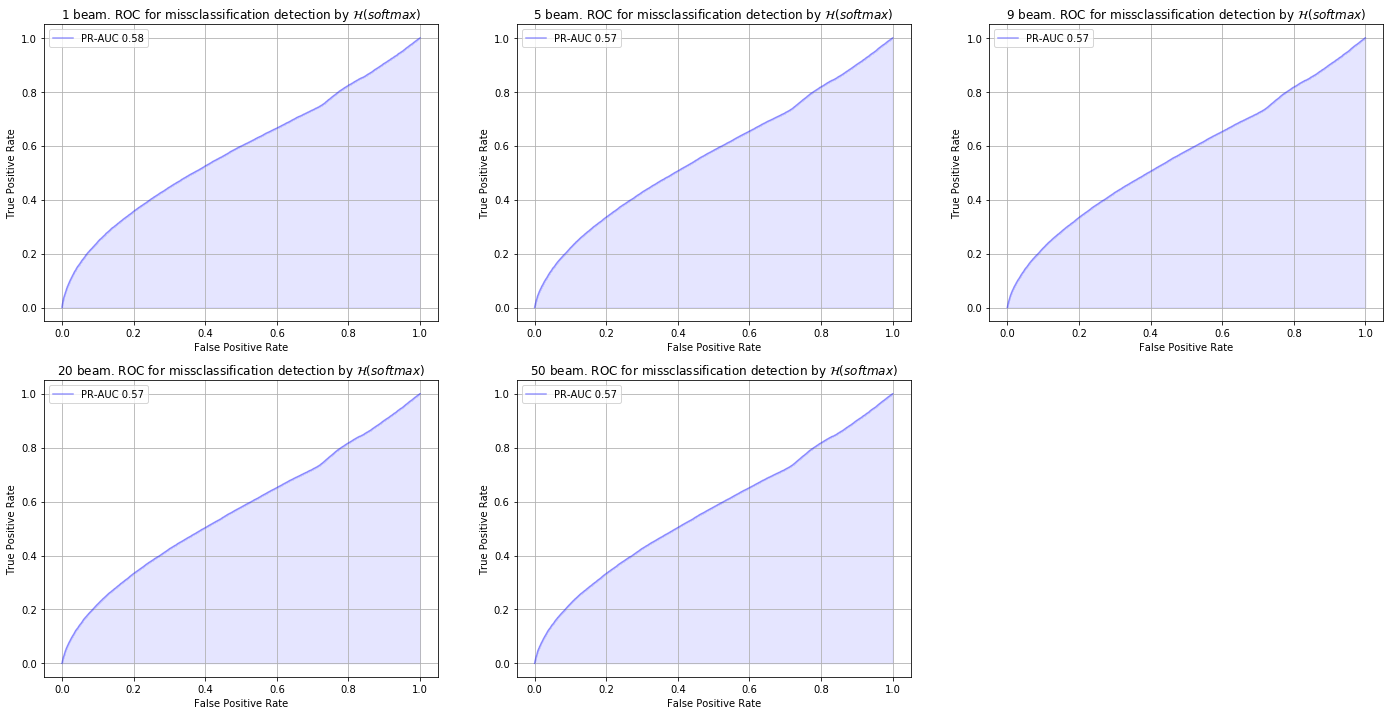

In [20]:
m = 3
n = len(beams) // m + (1 if len(beams) % m != 0 else 0)

plt.figure(figsize=(8 * m, 6 * n))
for i, beam in enumerate(sorted(beams)):
    ax = plt.subplot(n, m, i + 1)
    
    fpr, tpr, tr = roc_curve(
        beam2missclassification[beam],
        beam2entropy[beam]
    )
    
    ax.plot(
        fpr,
        tpr,
        alpha=.4,
        label='PR-AUC {:.2f}'.format(auc(fpr, tpr)),
        color='b'
    )
    ax.fill_between(fpr, tpr, alpha=0.1, color='b')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(str(beam) + ' beam. ROC for missclassification detection by $\mathcal{H}(softmax)$')
    ax.grid()
    ax.legend()